# Схема проекта: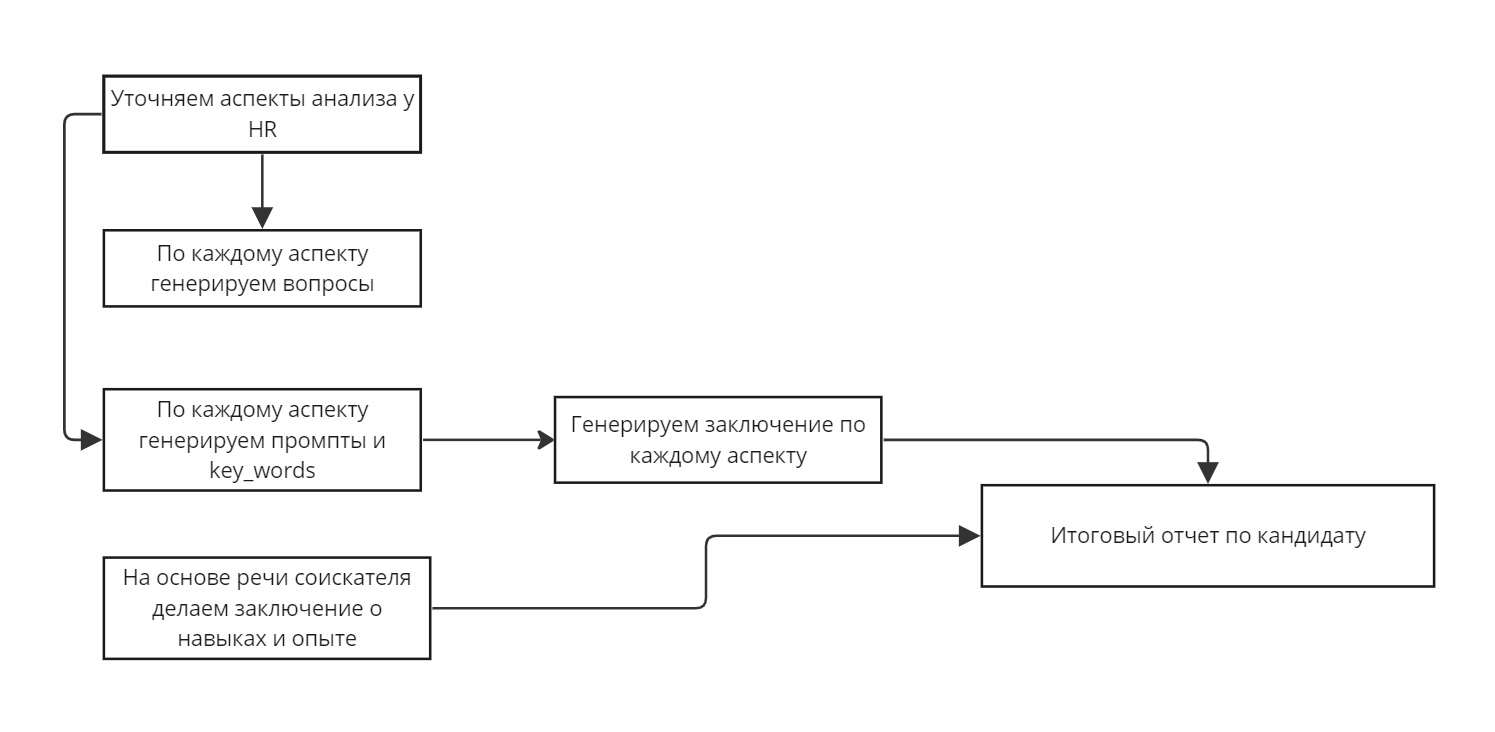

# Готовим диалог:

In [1]:
!pip install -q pydantic==2.10.6 tiktoken==0.7.0 openai==1.61.1 langchain==0.3.19 langchain_community==0.3.18 langchain-openai==0.3.6 faiss-cpu==1.8.0
from IPython.display import clear_output
clear_output()

In [3]:
import os
import re
from datetime import timedelta
import time
from IPython.display import HTML, clear_output
import subprocess
from pathlib import Path
import json
import ipywidgets as widgets
from IPython.display import display
from tqdm.auto import tqdm
import getpass
import pickle
#import torch
#import whisper
import openai
import codecs
from langchain.chains import ConversationChain         # Импортируем класс для создания цепочек диалогов
from langchain_openai import ChatOpenAI           # Импортируем класс для работы с чатами на базе OpenAI
from langchain.llms import OpenAI
from langchain.memory import ConversationBufferMemory  # Импортируем класс для управления памятью диалогов
from langchain.text_splitter import MarkdownHeaderTextSplitter, RecursiveCharacterTextSplitter, CharacterTextSplitter
from langchain.schema import (
    AIMessage,
    HumanMessage,
    SystemMessage
)
from langchain.docstore.document import Document
from langchain_openai import OpenAIEmbeddings
from langchain.vectorstores import Chroma, FAISS
from langchain.text_splitter import CharacterTextSplitter, RecursiveCharacterTextSplitter
from langchain.prompts import PromptTemplate
import pathlib
import tempfile
from IPython.display import HTML
import requests
# игнорирование предупреждений
import warnings
warnings.filterwarnings("ignore")
import logging
logging.getLogger("langchain.text_splitter").setLevel(logging.ERROR)
logging.getLogger("chromadb").setLevel(logging.ERROR)
import tiktoken

In [ ]:
from google.colab import drive
from google.colab import output
from google.colab import userdata
# инициируем ключи OpenAI через секрет
key = userdata.get('OPENAI_API_KEY')
os.environ["OPENAI_API_KEY"] = key

openai.api_key = key

In [ ]:
def load_document_text(url: str) -> str:
    # Extract the document ID from the URL
    match_ = re.search('/document/d/([a-zA-Z0-9-_]+)', url)
    if match_ is None:
        raise ValueError('Invalid Google Docs URL')
    doc_id = match_.group(1)

    # Download the document as plain text
    response = requests.get(f'https://docs.google.com/document/d/{doc_id}/export?format=txt')
    response.raise_for_status()
    text = response.text

    return text

In [ ]:
url = "https://docs.google.com/document/d/14PDkow15jxyAXsm0l196aefbRPmpYd3v0iJe0sPupY8/edit?usp=sharing"
dialogue = load_document_text(url)

In [ ]:
# вот в таком формате у нас диалог - есть разделение по ролям и тайминги:
dialogue

"\ufeff00:00 HR: Вижу последнее ваше место работы. Расскажите пожалуйста, почему пошли именно в эту компанию. И на чем основывался ваш выбор? \r\n00:06 Соискатель: А в данную компанию я пошла, потому что она удовлетворяла мои потребности на тот момент. Да, то есть мне было важно, чтобы это было недалеко от дома, чтобы это в тот опять же момент времени, чтобы это была новая сфера, так как я ранее работала в продажах, мне была интересна новая сфера аутсорс меня привлек, это было удобно в плане графика и месторасположения.\r\n00:31 HR: Вы работали удаленно или в офисе?\r\n00:39 Соискатель: Все время я работала в гибридном графике, то есть я два дня была в офисе, остальные дни я была на удаленке, но опять же такой график был не сразу. Изначально я работала в офисе первые полгода, потом уже перешла на гибрид.\r\n00:53 HR: Хорошо, Кей. Почему вы ушли из последнего места работы?\r\n00:54 Соискатель: В связи с последними ситуациями в нашей стране, к сожалению, у нас снизился поток проектов, и 

In [ ]:
# выделяем то, что говорил HR и то, что говорил соискатель, в отдельные файлы - нам это понадобится в дальнейшем при анализе

hr_part = []  # Использование списка для хранения частей диалога HR
applicant_part = []  # Использование списка для хранения частей диалога соискателя
current_speaker = None

# Разделяем диалог по ролям
for line in dialogue.strip().split('\n'):
    if 'HR:' in line:
        current_speaker = 'HR'
        hr_part.append(line)  # Добавление строки в список
    elif 'Соискатель:' in line:
        current_speaker = 'Соискатель'
        applicant_part.append(line)  # Добавление строки в список
    else:
        if current_speaker == 'HR':
            hr_part[-1] += ' ' + line  # Добавление строки к последнему элементу списка
        elif current_speaker == 'Соискатель':
            applicant_part[-1] += ' ' + line  # Добавление строки к последнему элементу списка

# Объединение элементов списков в строки
hr_part = '\n'.join(hr_part)
applicant_part = '\n'.join(applicant_part)

In [ ]:
hr_part

'\ufeff00:00 HR: Вижу последнее ваше место работы. Расскажите пожалуйста, почему пошли именно в эту компанию. И на чем основывался ваш выбор? \r\n00:31 HR: Вы работали удаленно или в офисе?\r\n00:53 HR: Хорошо, Кей. Почему вы ушли из последнего места работы?\r\n01:35 HR: Хорошо, я вот посмотрела ваши резюме, с чем вы занимались. Я вижу, что очень много чем вы руководствовали. Можете более подробно рассказать про ваш опыт? Потому что вижу, что вы с координаторами работы, бухгалтерии, специалисты по документообороту, то есть вы прям были помощником руководителя или вы руководителем были?\r\n03:44 HR: Поняла, то есть вы еще искали проекты в саму команду?\r\n03:47 HR: Окей, можете парочку компаний сказать, с которыми вы работали? То есть это, наверное, больше аутсорс, ритейл был, да, я так понимаю?\r\n04:21 HR: Хорошо, окей, поняла. Расскажите, пожалуйста, подробнее о опыте в качестве маркетолога. Что вы делали? То есть я вижу, что вы размещали вакансии, а что еще это было? Возможно, с Тел

# Запускаем алгоритм

In [ ]:
def create_embedding(data, chunk_size, chunk_overlap=0):
    # Выбор метода разбиения текста на фрагменты
    splitter = RecursiveCharacterTextSplitter(chunk_size=chunk_size, chunk_overlap=chunk_overlap, separators=["\n"])
    source_chunks = splitter.create_documents([data], metadatas=[{"meta": "meta"}])

    # Создание поискового индекса документов
    search_index = FAISS.from_documents(source_chunks, OpenAIEmbeddings())
    return search_index  # Возвращение поискового индекса

def insert_newlines(text: str, max_len: int = 170) -> str:
    words = text.split()
    lines = []
    current_line = ""
    for word in words:
        if len(current_line + " " + word) > max_len:
            lines.append(current_line)
            current_line = ""
        current_line += " " + word
    lines.append(current_line)
    return "\n".join(lines)

def answer_user_question(system_doc_text: str, knowledge_base_text, topic: str,
                         instructions: str, temperature: float, verbose: int, k: int, chunk_size: int, chunk_overlap: int, model: str) -> str:

    # Создаем индексы поиска
    knowledge_base_index = create_embedding(knowledge_base_text, chunk_size, chunk_overlap)
    # Извлечение наиболее похожих отрезков текста из базы знаний и получение ответа модели
    answer_text = answer_index(system_doc_text, topic, instructions, knowledge_base_index, temp=temperature, verbose=verbose, k=k, model=model)

    return insert_newlines(answer_text)

def answer_index(system, topic, instructions, search_index, temp=0, verbose=0, k=5, model='gpt-4o-mini'):

    # Selecting documents similar to the question
    # docs = search_index.similarity_search(topic, k=k)
    docs = search_index.similarity_search_with_score(topic, k=k)
    if verbose: print('===========================================')
    message_content = re.sub(r'\n{2}', ' ', '\n '.join([f'Отрывок текста №{i+1}\n=====================\n' + doc[0].page_content + '\n' for i, doc in enumerate(docs)]))
    if verbose: print('message_content:\n ========================================\n',
                         re.sub(r'\n{2}', ' ', '\n '.join([f'\nОтрывок текста №{i+1} Оценка схожести: {doc[1]}\n=====================\n' + doc[0].page_content + '\n' for i, doc in enumerate(docs)])))

    messages = [
        {"role": "system", "content": system},
        {"role": "user", "content": f"{instructions}\n\nТексты для анализа:\n{message_content}"}
    ]

    completion = openai.chat.completions.create(
        model=model,
        messages=messages,
        temperature=temp
    )

    answer = completion.choices[0].message.content
    return answer  # возвращает ответ вместо его вывода


def answer_user_question_from_answer(system, instructions, answers_content, temp=0, verbose=0, model='gpt-4o-mini'):

    if verbose: print('===========================================')
    if verbose: print(f'Результаты анализа:\n{answers_content}')
    messages = [
        {"role": "system", "content": system},
        {"role": "user", "content": f"{instructions}\n\nРезультаты анализа:\n{answers_content}"}
    ]

    if verbose: print('===========================================\n')

    completion = openai.chat.completions.create(
        model=model,
        messages=messages,
        temperature=temp
    )
    answer = completion.choices[0].message.content
    return insert_newlines(answer)  # возвращает ответ вместо его вывода

def simple_gpt_answer(system, user_assist, assistant, user, temp=0, model='gpt-4o-mini'):
    messages = [
        {"role": "system", "content": system},
        {"role": "user", "content": user_assist},
        {'role':'assistant', 'content': assistant},
        {"role": "user", "content": f"{user}"}

    ]
    completion = openai.chat.completions.create(
        model=model,
        messages=messages,
        temperature=temp
    )
    answer = completion.choices[0].message.content
    return insert_newlines(answer)  # возвращает ответ вместо его вывода

def num_tokens_from_string(string: str, encoding_name: str) -> int:
    """Returns the number of tokens in a text string."""
    encoding = tiktoken.get_encoding(encoding_name)
    num_tokens = len(encoding.encode(string))
    return num_tokens



# Уточнение задачи HR

In [ ]:
HR_requests = []  # Инициализация пустого списка для хранения строк

while True:
    user_input = input("Введите ключевые аспекты, по которым будут анализироваться слова соискателя на должность (или напишите 'exit' для завершения): ")
    if user_input.lower() == 'exit':
        break
    HR_requests.append(user_input)

Введите ключевые аспекты, по которым будут анализироваться слова соискателя на должность (или напишите 'exit' для завершения): К какой из ролей Адизеса относится соискатель, насколько хорошо соискатель адаптируется к различным ситуациям в команде и какие управленческие качества он проявляет
Введите ключевые аспекты, по которым будут анализироваться слова соискателя на должность (или напишите 'exit' для завершения): Оценка способности кандидата к систематическому подходу в работе по сравнению с неструктурированным и хаотичным стилем. Это включает анализ, как кандидат планирует и организует свою работу, управляет временем и ресурсами, а также его способность к сосредоточенному выполнению задач без отвлечения на мелочи. Цель – понять, насколько кандидат склонен к систематическому решению задач и избеганию непродуктивной суеты.
Введите ключевые аспекты, по которым будут анализироваться слова соискателя на должность (или напишите 'exit' для завершения): Определение, насколько кандидат фокус

In [ ]:
HR_requests

['К какой из ролей Адизеса относится соискатель, насколько хорошо соискатель адаптируется к различным ситуациям в команде и какие управленческие качества он проявляет',
 'Оценка способности кандидата к систематическому подходу в работе по сравнению с неструктурированным и хаотичным стилем. Это включает анализ, как кандидат планирует и организует свою работу, управляет временем и ресурсами, а также его способность к сосредоточенному выполнению задач без отвлечения на мелочи. Цель – понять, насколько кандидат склонен к систематическому решению задач и избеганию непродуктивной суеты.',
 'Определение, насколько кандидат фокусируется на конечных результатах или на процессе их достижения. Это помогает понять, как кандидат подходит к выполнению задач, решению проблем и достижению целей.',
 'Оценка способности кандидата быть инициатором новых проектов или эффективным продолжателем уже начатых процессов. Это помогает определить, насколько хорошо кандидат справится с задачами, требующими начальн

# Генерация вопросов для использования при собеседовании на позицию "помощник маркетолога"

In [ ]:
system_QG = "Ты-помощник HR в компании 'Университет искусственного интеллекта'. Ты всегда точно следуешь инструкциям"
user_assist_QG = """Сгенерируй несколько вопросов, при помощи которых HR во время собеседования на позицию помощника маркетолога мог бы было выявить у соискателя следующий аспект:
способность кандидата генерировать новые идеи, предлагать нестандартные решения и быть открытым для инноваций"""
assist_QG = """Расскажите о ситуации, когда вам удалось успешно решить проблему нестандартным способом.
Приведите пример, когда вы предложили новаторское решение для улучшения процесса или продукта в вашей предыдущей работе.
Как вы подходите к генерации новых идей в рамках маркетинговой кампании?
Опишите проект или задачу, где вы действовали за рамками установленных процедур или стандартов.
Можете ли вы привести пример, когда ваши инновационные идеи были успешно реализованы?"""
user_QG = "Сгенерируй несколько вопросов, при помощи которых HR во время собеседования на позицию помощника маркетолога мог бы было выявить у соискателя следующий аспект: {i}"
questions = []
for i in HR_requests:
    # Формируем строку , подставляя текущий элемент из HR_requests вместо {i}
    user_prompt_questions = user_QG.format(i=i)

    # Вызываем функцию simple_gpt_answer с обновленной строкой user_prompt_writer_modified
    ans = simple_gpt_answer(system_QG, user_assist_QG, assist_QG, user_prompt_questions, temp=0, model='gpt-4o-mini')

    # Добавляем полученный ответ в список prompts
    questions.append(ans)

In [ ]:
questions

[' Как вы обычно реагируете на изменения в команде или проекте? Приведите пример, когда вам пришлось адаптироваться к новой ситуации. Опишите ситуацию, когда вам пришлось\n взять на себя лидерство в команде. Какие управленческие качества вы проявили в этом случае? Как вы определяете свою роль в команде? Как вы считаете, к какой роли Адизеса\n вы больше всего склонны? Расскажите о случае, когда вам пришлось работать с людьми, имеющими разные подходы и стили работы. Как вы справились с этой ситуацией? Как вы\n поддерживаете баланс между выполнением задач и взаимодействием с командой? Приведите пример, когда вам удалось успешно объединить эти аспекты.',
 ' Как вы планируете свои задачи на день/неделю? Используете ли вы какие-либо инструменты или методики для организации рабочего процесса? Опишите ситуацию, когда вам\n пришлось управлять несколькими проектами одновременно. Как вы расставляли приоритеты и организовывали свое время? Как вы справляетесь с отвлекающими факторами на работе?\n Е

# Написание промптов по ключевым аспектам анализа соискателя

Основываясь на ключевых аспектах анализа соискателя, зафиксированных в списке HR_requests, генерируем промпты в user и ключевые слова в формате списка по каждому элементу из HR_requests.

In [ ]:
system_prompt_writer = """Ты-копирайтер, на 100% точно выполняющий инструкции. В итоге должен получиться список строк: в первом элементе списка - инструкция по созданию двух отчетов,
 во втором - список ключевых слов. Два отчета должны быть в следующем формате: первый отчет - краткий и концентрированный анализ, второй отчет - детальный, с цитатами"""
user_assist = """я готовлю программу по анализу собеседования на должность помощника маркетолога по нескольким пунктам. Тебе нужно написать инструкцию для анализа следующего
аспекта:  анализ способности кандидата генерировать новые идеи, предлагать нестандартные решения и быть открытым для инноваций. В итоге должен быть список из 2 элементов: инструкция
и ключевые слова, по которым в диалоге можно было бы выявить фразы соискателя на должность по теме: анализ способности кандидата генерировать новые идеи, предлагать нестандартные
решения и быть открытым для инноваций. Важно: сделай все в формате: список с инструкцией (2 отчета), ключевые слова. Первый отчет должен быть кратким и только по существу, в 2-3
предложениях, а второй отчет - детальный, развернутый анализ, с цитатами кандидата."""

assistant = """['Напиши 2 отчета: Первый отчет: кратко и концентрированно, в паре предложений, оцени, насколько кандидат способен быть креативным и инновационным в своей работе.
Второй отчет: Проанализируй детально способности кандидата генерировать новые идеи, предлагать нестандартные решения и быть открытым для инноваций. Оценка уровня креативности и
готовности к экспериментам, и почему ты сделал такой вывод. Какие фразы соискателя в диалоге могут быть ключевыми для оценки данного аспекта? Процитируй данные фразы.
В своих выводах основывайся только на представленных тебе отрезках диалога, не придумывай ничего от себя.',
'Креативность, инновации, инновационный подход, генерация идей, нестандартные решения, мышление "за рамками", экспериментирование, прорывные идеи, прорывное мышление, творческий подход,
открытость для нового']"""

user = """я готовлю программу по анализу собеседования на должность помощника маркетолога по нескольким пунктам. Тебе нужно написать инструкцию для анализа следующего
аспекта:  {i}. В итоге должен быть список из 2 элементов: инструкция и ключевые слова, по которым в диалоге можно было бы выявить фразы соискателя на должность по теме: {i}
Важно: сделай все в формате: список с инструкцией (2 отчета), ключевые слова. Первый отчет должен быть кратким и только по существу, в 2-3
предложениях, а второй отчет - детальный, развернутый анализ, с цитатами кандидата."""

prompts = []
for i in HR_requests:
    # Формируем строку user_prompt_writer, подставляя текущий элемент из HR_requests вместо {i}
    user_prompt_writer_modified = user.format(i=i)

    # Вызываем функцию simple_gpt_answer с обновленной строкой user_prompt_writer_modified
    ans = simple_gpt_answer(system_prompt_writer, user_assist, assistant, user_prompt_writer_modified, temp=0, model='gpt-4o-mini')

    # Добавляем полученный ответ в список prompts
    prompts.append(ans)


In [ ]:
prompts

[" ['Напиши 2 отчета: Первый отчет: кратко и концентрированно, в 2-3 предложениях, оцени, к какой роли Адизеса относится кандидат и как он адаптируется к различным\n ситуациям в команде, а также какие управленческие качества проявляет. Второй отчет: Проведи детальный анализ, определив роль кандидата по модели Адизеса, его способности\n к адаптации в команде и управленческие качества. Приведи конкретные цитаты кандидата, которые подтверждают твои выводы и объясни, почему ты пришел к таким выводам.',\n 'Роль Адизеса, адаптация, управленческие качества, командная работа, лидерство, гибкость, коммуникация, способность к сотрудничеству, разрешение конфликтов,\n инициативность, ответственность']",
 " ['Напиши 2 отчета: Первый отчет: кратко и концентрированно, в 2-3 предложениях оцени, насколько кандидат склонен к систематическому подходу в работе, как он планирует и\n организует свои задачи, управляет временем и ресурсами. Второй отчет: Проанализируй детально, как кандидат демонстрирует сист

In [ ]:
import ast
# Замена переносов строк на пробелы
modified_list = [item.replace('\n', ' ') for item in prompts]

# Преобразование каждой строки в список
converted_list = [ast.literal_eval(item) for item in modified_list]

print(converted_list)

[['Напиши 2 отчета: Первый отчет: кратко и концентрированно, в 2-3 предложениях, оцени, к какой роли Адизеса относится кандидат и как он адаптируется к различным  ситуациям в команде, а также какие управленческие качества проявляет. Второй отчет: Проведи детальный анализ, определив роль кандидата по модели Адизеса, его способности  к адаптации в команде и управленческие качества. Приведи конкретные цитаты кандидата, которые подтверждают твои выводы и объясни, почему ты пришел к таким выводам.', 'Роль Адизеса, адаптация, управленческие качества, командная работа, лидерство, гибкость, коммуникация, способность к сотрудничеству, разрешение конфликтов,  инициативность, ответственность'], ['Напиши 2 отчета: Первый отчет: кратко и концентрированно, в 2-3 предложениях оцени, насколько кандидат склонен к систематическому подходу в работе, как он планирует и  организует свои задачи, управляет временем и ресурсами. Второй отчет: Проанализируй детально, как кандидат демонстрирует систематический 

In [ ]:
# таким образом будем обращаться к элементам нашего списка - к промптам и ключевым словам
converted_list[0][1]

'Роль Адизеса, адаптация, управленческие качества, командная работа, лидерство, гибкость, коммуникация, способность к сотрудничеству, разрешение конфликтов,  инициативность, ответственность'

In [ ]:
converted_list[0][0]

'Напиши 2 отчета: Первый отчет: кратко и концентрированно, в 2-3 предложениях, оцени, к какой роли Адизеса относится кандидат и как он адаптируется к различным  ситуациям в команде, а также какие управленческие качества проявляет. Второй отчет: Проведи детальный анализ, определив роль кандидата по модели Адизеса, его способности  к адаптации в команде и управленческие качества. Приведи конкретные цитаты кандидата, которые подтверждают твои выводы и объясни, почему ты пришел к таким выводам.'

##Диалог

In [ ]:
#@title Подсчет токенов и их соотношение в диалоге между клиентом и менджером
num_token_dialog = num_tokens_from_string(dialogue, encoding_name="cl100k_base")
num_token_applicant = num_tokens_from_string(applicant_part, encoding_name="cl100k_base")
num_token_HR = num_tokens_from_string(hr_part, encoding_name="cl100k_base")
print('Токенов в Диалог: ', num_token_dialog)
print('Токенов в Соискатель +: ', num_token_applicant)
print('Токенов в HR +: ', num_token_HR)

# Проверка на нулевое общее количество токенов в диалоге для избежания деления на ноль
if num_token_dialog > 0:
    percent_applicant = (num_token_applicant * 100) / num_token_dialog
    percent_HR = (num_token_HR * 100) / num_token_dialog
    print("Процент токенов Соискатель: ", round(percent_applicant, 2), '%')
    print("Процент токенов HR: ", round(percent_HR, 2), '%')
else:
    print("Диалог не содержит токенов.")

Токенов в Диалог:  5042
Токенов в Соискатель +:  4004
Токенов в HR +:  1039
Процент токенов Соискатель:  79.41 %
Процент токенов HR:  20.61 %


**content** - *это выбор из какой базы будет использоваться текст для анализа*

**temperature** - *это значение чем меньше (ближе, либо равно нулю) чем точнее к контексту, чем ближе к 1 тем больше фантазии*

**num_fragment** - *это количество отрезков документа которые отбираются по ключевым фразам и передаются в модель для анализа (сейчас 5 так как при нынешней нарезке влезает в модель по количеству токенов в среднем около 3000, но может варьироваться)*

**system_prompt** - это роль модели и какие то глобальные установки

**instructions** - *это описание задачи что нужно сделать над отобранным контекстом по ключевым фразам*

**topicphrase** - *это ключевые слова для отбора отрывков текста в нужном смысле для анализа*

# Детализированные отчеты по пунктам:

Ты анализируешь диалог HR и соискателя на должность “помощник маркетолога”, в компанию "университет искусственного интеллекта". Твоя задача - проанализировать представленные тебе отрезки диалога и сделать 2 отчета в указанном порядке

In [ ]:
#@title 1.Определение, к какой из ролей Адизеса относится соискатель
model = "gpt-4o-mini" #@param ["gpt-4o-mini", "gpt-4o", "gpt-3.5-turbo-0125"]
temperature = 0 #@param {type: "slider", min: 0, max: 1, step:0.1}
content = 'Соискатель +' #@param ['Диалог', 'Соискатель +', 'HR +']
chunk_size = 816 #@param {type: "slider", min: 200, max: 1024, step:8}
chunk_overlap = 0 #@param {type: "slider", min: 0, max: 256, step:8}
num_fragment = 8 #@param {type:"integer"}
system_prompt = "\u0422\u044B \u0430\u043D\u0430\u043B\u0438\u0437\u0438\u0440\u0443\u0435\u0448\u044C \u0434\u0438\u0430\u043B\u043E\u0433 HR \u0438 \u0441\u043E\u0438\u0441\u043A\u0430\u0442\u0435\u043B\u044F \u043D\u0430 \u0434\u043E\u043B\u0436\u043D\u043E\u0441\u0442\u044C \u201C\u043F\u043E\u043C\u043E\u0449\u043D\u0438\u043A \u043C\u0430\u0440\u043A\u0435\u0442\u043E\u043B\u043E\u0433\u0430\u201D, \u0432 \u043A\u043E\u043C\u043F\u0430\u043D\u0438\u044E \"\u0443\u043D\u0438\u0432\u0435\u0440\u0441\u0438\u0442\u0435\u0442 \u0438\u0441\u043A\u0443\u0441\u0441\u0442\u0432\u0435\u043D\u043D\u043E\u0433\u043E \u0438\u043D\u0442\u0435\u043B\u043B\u0435\u043A\u0442\u0430\". \u0422\u0432\u043E\u044F \u0437\u0430\u0434\u0430\u0447\u0430 - \u043F\u0440\u043E\u0430\u043D\u0430\u043B\u0438\u0437\u0438\u0440\u043E\u0432\u0430\u0442\u044C \u043F\u0440\u0435\u0434\u0441\u0442\u0430\u0432\u043B\u0435\u043D\u043D\u044B\u0435 \u0442\u0435\u0431\u0435 \u043E\u0442\u0440\u0435\u0437\u043A\u0438 \u0434\u0438\u0430\u043B\u043E\u0433\u0430 \u0438 \u0441\u0434\u0435\u043B\u0430\u0442\u044C 2 \u043E\u0442\u0447\u0435\u0442\u0430 \u0432 \u0443\u043A\u0430\u0437\u0430\u043D\u043D\u043E\u043C \u043F\u043E\u0440\u044F\u0434\u043A\u0435" #@param {type:"string"}
instructions = converted_list[0][0]
topicphrase = converted_list[0][1]

if content == 'Диалог':
  content_base = dialogue
elif content == 'Соискатель +':
  content_base = applicant_part
elif content == 'HR +':
  content_base = hr_part
output1 = answer_user_question(system_prompt, content_base, topicphrase,
                               instructions, temperature, 0, num_fragment,
                               chunk_size, chunk_overlap, model)
print("\nОтвет:\n", output1)


Ответ:
  ### Первый отчет: Кандидат на должность помощника маркетолога в компании "университет искусственного интеллекта" проявляет качества, соответствующие роли "интегратора"
 по модели Адизеса. Она демонстрирует способность адаптироваться к различным ситуациям в команде, подчеркивая важность дружеской атмосферы и совместной работы.
 Управленческие качества кандидата проявляются в умении находить компромиссы и решать сложные задачи, что свидетельствует о ее гибкости и ориентации на командные цели.
 ### Второй отчет: Кандидат, судя по ее высказываниям, занимает роль "интегратора" по модели Адизеса. Она акцентирует внимание на важности дружеских отношений в
 коллективе и совместной работе, что подтверждается ее словами: "если я столкнусь с токсичным коллективом, я постараюсь как-то, так скажем, простимулировать его к
 позитивным моментам". Это говорит о ее стремлении к созданию гармоничной атмосферы в команде. Кандидат также демонстрирует высокую способность к адаптации, что видно из


In [ ]:
#@title 2.Системность vs Суетология
model = "gpt-4o-mini" #@param ["gpt-4o-mini", "gpt-4o", "gpt-3.5-turbo-0125"]
content = '\u0421\u043E\u0438\u0441\u043A\u0430\u0442\u0435\u043B\u044C +' #@param ['Диалог', 'Соискатель +', 'HR +']
chunk_size = 688 #@param {type: "slider", min: 200, max: 1024, step:8}
chunk_overlap = 0 #@param {type: "slider", min: 0, max: 256, step:8}
temperature = 0 #@param {type: "slider", min: 0, max: 1, step:0.1}
num_fragment = 8 #@param {type:"integer"}
system_prompt = "\u0422\u044B \u0430\u043D\u0430\u043B\u0438\u0437\u0438\u0440\u0443\u0435\u0448\u044C \u0434\u0438\u0430\u043B\u043E\u0433 HR \u0438 \u0441\u043E\u0438\u0441\u043A\u0430\u0442\u0435\u043B\u044F \u043D\u0430 \u0434\u043E\u043B\u0436\u043D\u043E\u0441\u0442\u044C \u201C\u043F\u043E\u043C\u043E\u0449\u043D\u0438\u043A \u043C\u0430\u0440\u043A\u0435\u0442\u043E\u043B\u043E\u0433\u0430\u201D, \u0432 \u043A\u043E\u043C\u043F\u0430\u043D\u0438\u044E \"\u0443\u043D\u0438\u0432\u0435\u0440\u0441\u0438\u0442\u0435\u0442 \u0438\u0441\u043A\u0443\u0441\u0441\u0442\u0432\u0435\u043D\u043D\u043E\u0433\u043E \u0438\u043D\u0442\u0435\u043B\u043B\u0435\u043A\u0442\u0430\". \u0422\u0432\u043E\u044F \u0437\u0430\u0434\u0430\u0447\u0430 - \u043F\u0440\u043E\u0430\u043D\u0430\u043B\u0438\u0437\u0438\u0440\u043E\u0432\u0430\u0442\u044C \u043F\u0440\u0435\u0434\u0441\u0442\u0430\u0432\u043B\u0435\u043D\u043D\u044B\u0435 \u0442\u0435\u0431\u0435 \u043E\u0442\u0440\u0435\u0437\u043A\u0438 \u0434\u0438\u0430\u043B\u043E\u0433\u0430 \u0438 \u0441\u0434\u0435\u043B\u0430\u0442\u044C 2 \u043E\u0442\u0447\u0435\u0442\u0430 \u0432 \u0443\u043A\u0430\u0437\u0430\u043D\u043D\u043E\u043C \u043F\u043E\u0440\u044F\u0434\u043A\u0435" #@param {type:"string"}
instructions = converted_list[1][0]
topicphrase = converted_list[1][1]


if content == 'Диалог':
  content_base = dialogue
elif content == 'Соискатель +':
  content_base = applicant_part
elif content == 'HR +':
  content_base = hr_part

output2 = answer_user_question(system_prompt, content_base, topicphrase,
                               instructions, temperature, 0, num_fragment,
                               chunk_size, chunk_overlap, model) #ОБЩИЙ

print("\nОтвет:\n", output2)


Ответ:
  ### Первый отчет Кандидат демонстрирует склонность к систематическому подходу в работе, что проявляется в его способности организовывать задачи по приоритетам и
 дедлайнам. Он планирует свою работу, начиная с более простых задач, чтобы быстро завершить их, и заканчивая более сложными, что позволяет ему эффективно управлять
 временем и ресурсами. ### Второй отчет Кандидат проявляет высокий уровень организованности и сосредоточенности на задачах. Он упоминает: "Я уточню дедлайн, дедлайн этих
 задач, да, если дедлайн, ну, не будет, то, соответственно, если они одинаково важны, я начну с той, которая мне более легко, так скажем, дается". Это показывает его
 способность расставлять приоритеты и адаптироваться к условиям работы. Кроме того, он делится опытом оптимизации процессов: "Мы договорились, ну, совместно с
 программистом, придумали систему, воспользовались Яндекс-возможностями и сделали заявки на карте". Это свидетельствует о его инициативности и умении находить решения для

In [ ]:
#@title 3. Ориентация на процесс или на результат
model = "gpt-4o-mini" #@param ["gpt-4o-mini", "gpt-4o", "gpt-3.5-turbo-0125"]
content = '\u0421\u043E\u0438\u0441\u043A\u0430\u0442\u0435\u043B\u044C +' #@param ['Диалог', 'Соискатель +', 'HR +']
chunk_size = 712 #@param {type: "slider", min: 200, max: 1024, step:8}
chunk_overlap = 0 #@param {type: "slider", min: 0, max: 256, step:8}
temperature = 0 #@param {type: "slider", min: 0, max: 1, step:0.1}
num_fragment = 7 #@param {type:"integer"}
system_prompt = "\u0422\u044B \u0430\u043D\u0430\u043B\u0438\u0437\u0438\u0440\u0443\u0435\u0448\u044C \u0434\u0438\u0430\u043B\u043E\u0433 HR \u0438 \u0441\u043E\u0438\u0441\u043A\u0430\u0442\u0435\u043B\u044F \u043D\u0430 \u0434\u043E\u043B\u0436\u043D\u043E\u0441\u0442\u044C \u201C\u043F\u043E\u043C\u043E\u0449\u043D\u0438\u043A \u043C\u0430\u0440\u043A\u0435\u0442\u043E\u043B\u043E\u0433\u0430\u201D, \u0432 \u043A\u043E\u043C\u043F\u0430\u043D\u0438\u044E \"\u0443\u043D\u0438\u0432\u0435\u0440\u0441\u0438\u0442\u0435\u0442 \u0438\u0441\u043A\u0443\u0441\u0441\u0442\u0432\u0435\u043D\u043D\u043E\u0433\u043E \u0438\u043D\u0442\u0435\u043B\u043B\u0435\u043A\u0442\u0430\". \u0422\u0432\u043E\u044F \u0437\u0430\u0434\u0430\u0447\u0430 - \u043F\u0440\u043E\u0430\u043D\u0430\u043B\u0438\u0437\u0438\u0440\u043E\u0432\u0430\u0442\u044C \u043F\u0440\u0435\u0434\u0441\u0442\u0430\u0432\u043B\u0435\u043D\u043D\u044B\u0435 \u0442\u0435\u0431\u0435 \u043E\u0442\u0440\u0435\u0437\u043A\u0438 \u0434\u0438\u0430\u043B\u043E\u0433\u0430 \u0438 \u0441\u0434\u0435\u043B\u0430\u0442\u044C 2 \u043E\u0442\u0447\u0435\u0442\u0430 \u0432 \u0443\u043A\u0430\u0437\u0430\u043D\u043D\u043E\u043C \u043F\u043E\u0440\u044F\u0434\u043A\u0435" #@param {type:"string"}
instructions = converted_list[2][0]
topicphrase = converted_list[2][1]

if content == 'Диалог':
  content_base = dialogue
elif content == 'Соискатель +':
  content_base = applicant_part
elif content == 'HR +':
  content_base = hr_part

output3 = answer_user_question(system_prompt, content_base, topicphrase,
                               instructions, temperature, 0, num_fragment,
                               chunk_size, chunk_overlap, model) #ОБЩИЙ

print("\nОтвет:\n", output3)


Ответ:
  ### Первый отчет Кандидат ориентирован на конечные результаты, что видно из его подхода к выполнению задач и решению проблем. Он акцентирует внимание на важности
 достижения целей и роста, а также демонстрирует способность адаптироваться к изменениям и находить эффективные решения. ### Второй отчет Кандидат проявляет фокус на
 результатах, что видно из его высказываний и примеров из предыдущего опыта. Например, он говорит: "Мне важно, чтобы компания развивалась, в которой я работаю, да и
 чтобы, так скажем, мой труд не был напрасен", что подчеркивает его стремление к значимости своего вклада. Также он делится опытом, когда ему было поручено сложное
 решение: "Мне было это тяжело, потому что девочки все очень хорошо работали... но в конечном итоге я договорилась с девочками... увеличили объем работы на девочек, но
 никого не уволила". Это показывает его способность находить компромиссы и достигать целей, не прибегая к крайним мерам. Кандидат также упоминает, что "мы договорили

In [ ]:
#@title 4. Склонность к инициации или к продолжению процессов
model = "gpt-4o-mini" #@param ["gpt-4o-mini", "gpt-4o", "gpt-3.5-turbo-0125"]
content = '\u0421\u043E\u0438\u0441\u043A\u0430\u0442\u0435\u043B\u044C +' #@param ['Диалог', 'Соискатель +', 'HR +']
chunk_size = 800 #@param {type: "slider", min: 200, max: 1024, step:8}
chunk_overlap = 0 #@param {type: "slider", min: 0, max: 256, step:8}
temperature = 0 #@param {type: "slider", min: 0, max: 1, step:0.1}
num_fragment = 9 #@param {type:"integer"}
system_prompt = "\u0422\u044B \u0430\u043D\u0430\u043B\u0438\u0437\u0438\u0440\u0443\u0435\u0448\u044C \u0434\u0438\u0430\u043B\u043E\u0433 HR \u0438 \u0441\u043E\u0438\u0441\u043A\u0430\u0442\u0435\u043B\u044F \u043D\u0430 \u0434\u043E\u043B\u0436\u043D\u043E\u0441\u0442\u044C \u201C\u043F\u043E\u043C\u043E\u0449\u043D\u0438\u043A \u043C\u0430\u0440\u043A\u0435\u0442\u043E\u043B\u043E\u0433\u0430\u201D, \u0432 \u043A\u043E\u043C\u043F\u0430\u043D\u0438\u044E \"\u0443\u043D\u0438\u0432\u0435\u0440\u0441\u0438\u0442\u0435\u0442 \u0438\u0441\u043A\u0443\u0441\u0441\u0442\u0432\u0435\u043D\u043D\u043E\u0433\u043E \u0438\u043D\u0442\u0435\u043B\u043B\u0435\u043A\u0442\u0430\". \u0422\u0432\u043E\u044F \u0437\u0430\u0434\u0430\u0447\u0430 - \u043F\u0440\u043E\u0430\u043D\u0430\u043B\u0438\u0437\u0438\u0440\u043E\u0432\u0430\u0442\u044C \u043F\u0440\u0435\u0434\u0441\u0442\u0430\u0432\u043B\u0435\u043D\u043D\u044B\u0435 \u0442\u0435\u0431\u0435 \u043E\u0442\u0440\u0435\u0437\u043A\u0438 \u0434\u0438\u0430\u043B\u043E\u0433\u0430 \u0438 \u0441\u0434\u0435\u043B\u0430\u0442\u044C 2 \u043E\u0442\u0447\u0435\u0442\u0430 \u0432 \u0443\u043A\u0430\u0437\u0430\u043D\u043D\u043E\u043C \u043F\u043E\u0440\u044F\u0434\u043A\u0435" #@param {type:"string"}
instructions = converted_list[3][0]
topicphrase = converted_list[3][1]

if content == 'Диалог':
  content_base = dialogue
elif content == 'Соискатель +':
  content_base = applicant_part
elif content == 'HR +':
  content_base = hr_part

output4 = answer_user_question(system_prompt, content_base, topicphrase,
                               instructions, temperature, 0, num_fragment,
                               chunk_size, chunk_overlap, model) #ОБЩИЙ

print("\nОтвет:\n", output4)


Ответ:
  ### Первый отчет Кандидат демонстрирует способность быть инициатором новых проектов, что подтверждается его опытом в поиске новых источников для размещения вакансий и
 разработкой системы для упрощения работы рекрутеров. Он также проявляет интерес к аналитике и новым задачам, что указывает на его готовность к активному участию в
 развитии компании. ### Второй отчет Кандидат справляется с задачами, требующими начальной творческой инициативы, благодаря своему опыту в поиске новых источников для
 рекрутинга и разработке удобной системы для работы с заявками. Он говорит: "Я пыталась найти новые источники, помимо HeadHunter, Авито", что иллюстрирует его проактивный
 подход. В то же время, он также способен поддерживать и развивать существующие процессы, как видно из его примера с улучшением формы подачи заявок: "Мы договорились, ну,
 совместно с программистом, придумали систему, воспользовались Яндекс-возможностями и сделали заявки на карте". Это показывает его умение не только ин

In [ ]:
#@title 5. Уровень Амбиций и Направленность на Сложные Задачи
model = "gpt-4o-mini" #@param ["gpt-4o-mini", "gpt-4o", "gpt-3.5-turbo-0125"]
content = '\u0421\u043E\u0438\u0441\u043A\u0430\u0442\u0435\u043B\u044C +' #@param ['Диалог', 'Соискатель +', 'HR +']
chunk_size = 1024 #@param {type: "slider", min: 200, max: 1024, step:8}
chunk_overlap = 0 #@param {type: "slider", min: 0, max: 256, step:8}
temperature = 0 #@param {type: "slider", min: 0, max: 1, step:0.1}
num_fragment = 9 #@param {type:"integer"}
system_prompt = "\u0422\u044B \u0430\u043D\u0430\u043B\u0438\u0437\u0438\u0440\u0443\u0435\u0448\u044C \u0434\u0438\u0430\u043B\u043E\u0433 HR \u0438 \u0441\u043E\u0438\u0441\u043A\u0430\u0442\u0435\u043B\u044F \u043D\u0430 \u0434\u043E\u043B\u0436\u043D\u043E\u0441\u0442\u044C \u201C\u043F\u043E\u043C\u043E\u0449\u043D\u0438\u043A \u043C\u0430\u0440\u043A\u0435\u0442\u043E\u043B\u043E\u0433\u0430\u201D, \u0432 \u043A\u043E\u043C\u043F\u0430\u043D\u0438\u044E \"\u0443\u043D\u0438\u0432\u0435\u0440\u0441\u0438\u0442\u0435\u0442 \u0438\u0441\u043A\u0443\u0441\u0441\u0442\u0432\u0435\u043D\u043D\u043E\u0433\u043E \u0438\u043D\u0442\u0435\u043B\u043B\u0435\u043A\u0442\u0430\". \u0422\u0432\u043E\u044F \u0437\u0430\u0434\u0430\u0447\u0430 - \u043F\u0440\u043E\u0430\u043D\u0430\u043B\u0438\u0437\u0438\u0440\u043E\u0432\u0430\u0442\u044C \u043F\u0440\u0435\u0434\u0441\u0442\u0430\u0432\u043B\u0435\u043D\u043D\u044B\u0435 \u0442\u0435\u0431\u0435 \u043E\u0442\u0440\u0435\u0437\u043A\u0438 \u0434\u0438\u0430\u043B\u043E\u0433\u0430 \u0438 \u0441\u0434\u0435\u043B\u0430\u0442\u044C 2 \u043E\u0442\u0447\u0435\u0442\u0430 \u0432 \u0443\u043A\u0430\u0437\u0430\u043D\u043D\u043E\u043C \u043F\u043E\u0440\u044F\u0434\u043A\u0435" #@param {type:"string"}
instructions = converted_list[4][0]
topicphrase = converted_list[4][1]

if content == 'Диалог':
  content_base = dialogue
elif content == 'Соискатель +':
  content_base = applicant_part
elif content == 'HR +':
  content_base = hr_part

output5 = answer_user_question(system_prompt, content_base, topicphrase,
                               instructions, temperature, 0, num_fragment,
                               chunk_size, chunk_overlap, model) #ОБЩИЙ

print("\nОтвет:\n", output5)


Ответ:
  ### Первый отчет: Кандидат демонстрирует высокую амбициозность и готовность к сложным задачам, что подтверждается его стремлением к профессиональному росту и желанием
 развиваться в сфере маркетинга и искусственного интеллекта. Он активно ищет возможности для обучения и улучшения своих навыков, что свидетельствует о его
 целеустремленности. ### Второй отчет: Кандидат проявляет значительные амбиции и готовность принимать вызовы, что видно из его опыта и подхода к работе. Например, он
 упоминает, что за полгода работы в предыдущей компании смог вырасти с координатора до помощника операционного директора, что говорит о его стремлении к карьерному росту:
 "для меня это было очень большое достижение". Кандидат также демонстрирует способность справляться с трудными задачами. В одном из примеров он рассказывает о моральной
 сложности, связанной с увольнением сотрудника, и о том, как ему удалось найти компромисс, увеличив объем работы для оставшихся сотрудников: "мне было тяжело, пот

In [ ]:
#@title 6. Стрессоустойчивость и адаптация к изменениям
model = "gpt-4o-mini" #@param ["gpt-4o-mini", "gpt-4o", "gpt-3.5-turbo-0125"]
content = '\u0421\u043E\u0438\u0441\u043A\u0430\u0442\u0435\u043B\u044C +' #@param ['Диалог', 'Соискатель +', 'HR +']
chunk_size = 1024 #@param {type: "slider", min: 200, max: 1024, step:8}
chunk_overlap = 0 #@param {type: "slider", min: 0, max: 256, step:8}
temperature = 0 #@param {type: "slider", min: 0, max: 1, step:0.1}
num_fragment = 7 #@param {type:"integer"}
system_prompt = "\u0422\u044B \u0430\u043D\u0430\u043B\u0438\u0437\u0438\u0440\u0443\u0435\u0448\u044C \u0434\u0438\u0430\u043B\u043E\u0433 HR \u0438 \u0441\u043E\u0438\u0441\u043A\u0430\u0442\u0435\u043B\u044F \u043D\u0430 \u0434\u043E\u043B\u0436\u043D\u043E\u0441\u0442\u044C \u201C\u043F\u043E\u043C\u043E\u0449\u043D\u0438\u043A \u043C\u0430\u0440\u043A\u0435\u0442\u043E\u043B\u043E\u0433\u0430\u201D, \u0432 \u043A\u043E\u043C\u043F\u0430\u043D\u0438\u044E \"\u0443\u043D\u0438\u0432\u0435\u0440\u0441\u0438\u0442\u0435\u0442 \u0438\u0441\u043A\u0443\u0441\u0441\u0442\u0432\u0435\u043D\u043D\u043E\u0433\u043E \u0438\u043D\u0442\u0435\u043B\u043B\u0435\u043A\u0442\u0430\". \u0422\u0432\u043E\u044F \u0437\u0430\u0434\u0430\u0447\u0430 - \u043F\u0440\u043E\u0430\u043D\u0430\u043B\u0438\u0437\u0438\u0440\u043E\u0432\u0430\u0442\u044C \u043F\u0440\u0435\u0434\u0441\u0442\u0430\u0432\u043B\u0435\u043D\u043D\u044B\u0435 \u0442\u0435\u0431\u0435 \u043E\u0442\u0440\u0435\u0437\u043A\u0438 \u0434\u0438\u0430\u043B\u043E\u0433\u0430 \u0438 \u0441\u0434\u0435\u043B\u0430\u0442\u044C 2 \u043E\u0442\u0447\u0435\u0442\u0430 \u0432 \u0443\u043A\u0430\u0437\u0430\u043D\u043D\u043E\u043C \u043F\u043E\u0440\u044F\u0434\u043A\u0435" #@param {type:"string"}
instructions = converted_list[5][0]
topicphrase = converted_list[5][1]

if content == 'Диалог':
  content_base = dialogue
elif content == 'Соискатель +':
  content_base = applicant_part
elif content == 'HR +':
  content_base = hr_part

output6 = answer_user_question(system_prompt, content_base, topicphrase,
                               instructions, temperature, 0, num_fragment,
                               chunk_size, chunk_overlap, model) #ОБЩИЙ

print("\nОтвет:\n", output6)


Ответ:
  ### Первый отчет: Кандидат демонстрирует высокую способность адаптироваться к быстро меняющимся условиям работы и управлять стрессом. Он активно использует стратегию
 приоритизации задач и готов к многозадачности, что позволяет ему эффективно справляться с давлением и неожиданными ситуациями. ### Второй отчет: Кандидат проявляет
 уверенность в своей способности адаптироваться к изменениям и управлять стрессом. Например, он говорит: "если дедлайн, ну, не будет, то, соответственно, если они
 одинаково важны, я начну с той, которая мне более легко, так скажем, дается". Это показывает его подход к приоритизации задач и умение находить оптимальные решения в
 условиях неопределенности. Также он делится опытом, когда ему было предложено уволить сотрудника: "это был прям такой бум кого-то уволить, но получилось выкрутиться".
 Это свидетельствует о его способности справляться с моральным давлением и находить альтернативные решения, что говорит о высоком уровне эмоционального интеллект

In [ ]:
#@title 7. Ответственность и Признание Результатов
model = "gpt-4o-mini" #@param ["gpt-4o-mini", "gpt-4o", "gpt-3.5-turbo-0125"]
content = '\u0421\u043E\u0438\u0441\u043A\u0430\u0442\u0435\u043B\u044C +' #@param ['Диалог', 'Соискатель +', 'HR +']
chunk_size = 912 #@param {type: "slider", min: 200, max: 1024, step:8}
chunk_overlap = 0 #@param {type: "slider", min: 0, max: 256, step:8}
temperature = 0 #@param {type: "slider", min: 0, max: 1, step:0.1}
num_fragment = 6 #@param {type:"integer"}
system_prompt = "\u0422\u044B \u0430\u043D\u0430\u043B\u0438\u0437\u0438\u0440\u0443\u0435\u0448\u044C \u0434\u0438\u0430\u043B\u043E\u0433 HR \u0438 \u0441\u043E\u0438\u0441\u043A\u0430\u0442\u0435\u043B\u044F \u043D\u0430 \u0434\u043E\u043B\u0436\u043D\u043E\u0441\u0442\u044C \u201C\u043F\u043E\u043C\u043E\u0449\u043D\u0438\u043A \u043C\u0430\u0440\u043A\u0435\u0442\u043E\u043B\u043E\u0433\u0430\u201D, \u0432 \u043A\u043E\u043C\u043F\u0430\u043D\u0438\u044E \"\u0443\u043D\u0438\u0432\u0435\u0440\u0441\u0438\u0442\u0435\u0442 \u0438\u0441\u043A\u0443\u0441\u0441\u0442\u0432\u0435\u043D\u043D\u043E\u0433\u043E \u0438\u043D\u0442\u0435\u043B\u043B\u0435\u043A\u0442\u0430\". \u0422\u0432\u043E\u044F \u0437\u0430\u0434\u0430\u0447\u0430 - \u043F\u0440\u043E\u0430\u043D\u0430\u043B\u0438\u0437\u0438\u0440\u043E\u0432\u0430\u0442\u044C \u043F\u0440\u0435\u0434\u0441\u0442\u0430\u0432\u043B\u0435\u043D\u043D\u044B\u0435 \u0442\u0435\u0431\u0435 \u043E\u0442\u0440\u0435\u0437\u043A\u0438 \u0434\u0438\u0430\u043B\u043E\u0433\u0430 \u0438 \u0441\u0434\u0435\u043B\u0430\u0442\u044C 2 \u043E\u0442\u0447\u0435\u0442\u0430 \u0432 \u0443\u043A\u0430\u0437\u0430\u043D\u043D\u043E\u043C \u043F\u043E\u0440\u044F\u0434\u043A\u0435" #@param {type:"string"}
instructions = converted_list[6][0]
topicphrase = converted_list[6][1]

if content == 'Диалог':
  content_base = dialogue
elif content == 'Соискатель +':
  content_base = applicant_part
elif content == 'HR +':
  content_base = hr_part

output7 = answer_user_question(system_prompt, content_base, topicphrase,
                               instructions, temperature, 0, num_fragment,
                               chunk_size, chunk_overlap, model) #ОБЩИЙ

print("\nОтвет:\n", output7)


Ответ:
  ### Первый отчет Кандидат демонстрирует готовность брать на себя ответственность за результаты своих действий, признавая важность развития компании и своего вклада в
 это. Он открыто говорит о своих достижениях и неудачах, а также проявляет готовность учиться на ошибках, что свидетельствует о его способности воспринимать обратную
 связь. ### Второй отчет Кандидат признает свою роль в достижениях, упоминая, что за полгода работы в предыдущей компании он вырос до помощника операционного директора,
 что он считает значительным успехом: "это то, что изначально я пришла туда работать координатором, за полгода я выросла до помощника операционного директора". Он также
 осознает важность позитивной атмосферы в коллективе и готов принимать решения, если столкнется с токсичностью: "если я столкнусь с токсичным коллективом, я постараюсь
 как-то, так скажем, простимулировать его к позитивным моментам, но если не получится, я приму решение уйти". Это говорит о его готовности к самоанализу

In [ ]:
#@title 8. Приоритеты и Ценностные Ориентиры соискателя
model = "gpt-4o-mini" #@param ["gpt-4o-mini", "gpt-4o", "gpt-3.5-turbo-0125"]
content = '\u0421\u043E\u0438\u0441\u043A\u0430\u0442\u0435\u043B\u044C +' #@param ['Диалог', 'Соискатель +', 'HR +']
chunk_size = 1024 #@param {type: "slider", min: 200, max: 1024, step:8}
chunk_overlap = 0 #@param {type: "slider", min: 0, max: 256, step:8}
temperature = 0 #@param {type: "slider", min: 0, max: 1, step:0.1}
num_fragment = 4 #@param {type:"integer"}
system_prompt = "\u0422\u044B \u0430\u043D\u0430\u043B\u0438\u0437\u0438\u0440\u0443\u0435\u0448\u044C \u0434\u0438\u0430\u043B\u043E\u0433 HR \u0438 \u0441\u043E\u0438\u0441\u043A\u0430\u0442\u0435\u043B\u044F \u043D\u0430 \u0434\u043E\u043B\u0436\u043D\u043E\u0441\u0442\u044C \u201C\u043F\u043E\u043C\u043E\u0449\u043D\u0438\u043A \u043C\u0430\u0440\u043A\u0435\u0442\u043E\u043B\u043E\u0433\u0430\u201D, \u0432 \u043A\u043E\u043C\u043F\u0430\u043D\u0438\u044E \"\u0443\u043D\u0438\u0432\u0435\u0440\u0441\u0438\u0442\u0435\u0442 \u0438\u0441\u043A\u0443\u0441\u0441\u0442\u0432\u0435\u043D\u043D\u043E\u0433\u043E \u0438\u043D\u0442\u0435\u043B\u043B\u0435\u043A\u0442\u0430\". \u0422\u0432\u043E\u044F \u0437\u0430\u0434\u0430\u0447\u0430 - \u043F\u0440\u043E\u0430\u043D\u0430\u043B\u0438\u0437\u0438\u0440\u043E\u0432\u0430\u0442\u044C \u043F\u0440\u0435\u0434\u0441\u0442\u0430\u0432\u043B\u0435\u043D\u043D\u044B\u0435 \u0442\u0435\u0431\u0435 \u043E\u0442\u0440\u0435\u0437\u043A\u0438 \u0434\u0438\u0430\u043B\u043E\u0433\u0430 \u0438 \u0441\u0434\u0435\u043B\u0430\u0442\u044C 2 \u043E\u0442\u0447\u0435\u0442\u0430 \u0432 \u0443\u043A\u0430\u0437\u0430\u043D\u043D\u043E\u043C \u043F\u043E\u0440\u044F\u0434\u043A\u0435" #@param {type:"string"}
instructions = converted_list[7][0]
topicphrase = converted_list[7][1]

if content == 'Диалог':
  content_base = dialogue
elif content == 'Соискатель +':
  content_base = applicant_part
elif content == 'HR +':
  content_base = hr_part

output8 = answer_user_question(system_prompt, content_base, topicphrase,
                               instructions, temperature, 0, num_fragment,
                               chunk_size, chunk_overlap, model) #ОБЩИЙ

print("\nОтвет:\n", output8)


Ответ:
  ### Первый отчет: Кандидат расставляет приоритеты, акцентируя внимание на важности комфортной рабочей среды и возможности профессионального роста. Он ценит дружеские
 отношения в коллективе и стремится работать в компании, которая развивается и ценит своих сотрудников, что указывает на его желание сочетать работу с личным комфортом и
 стабильным доходом. ### Второй отчет: Кандидат демонстрирует сбалансированный подход к расстановке приоритетов между работой, семьей, доходом и комфортной жизнью. В
 своих ответах он подчеркивает важность позитивной атмосферы в коллективе, заявляя: "если я столкнусь с токсичным коллективом, я постараюсь как-то, так скажем,
 простимулировать его к позитивным моментам, но если не получится, я приму решение уйти". Это указывает на то, что для него комфортная рабочая среда является приоритетом,
 даже если это может повлиять на его доход. Кандидат также акцентирует внимание на необходимости развития компании, в которой он работает: "Мне важно, чтобы 

In [ ]:
#@title 9. Командная работа
model = "gpt-4o-mini" #@param ["gpt-4o-mini", "gpt-4o", "gpt-3.5-turbo-0125"]
content = '\u0421\u043E\u0438\u0441\u043A\u0430\u0442\u0435\u043B\u044C +' #@param ['Диалог', 'Соискатель +', 'HR +']
chunk_size = 1024 #@param {type: "slider", min: 200, max: 1024, step:8}
chunk_overlap = 0 #@param {type: "slider", min: 0, max: 256, step:8}
temperature = 0 #@param {type: "slider", min: 0, max: 1, step:0.1}
num_fragment = 7 #@param {type:"integer"}
system_prompt = "\u0422\u044B \u0430\u043D\u0430\u043B\u0438\u0437\u0438\u0440\u0443\u0435\u0448\u044C \u0434\u0438\u0430\u043B\u043E\u0433 HR \u0438 \u0441\u043E\u0438\u0441\u043A\u0430\u0442\u0435\u043B\u044F \u043D\u0430 \u0434\u043E\u043B\u0436\u043D\u043E\u0441\u0442\u044C \u201C\u043F\u043E\u043C\u043E\u0449\u043D\u0438\u043A \u043C\u0430\u0440\u043A\u0435\u0442\u043E\u043B\u043E\u0433\u0430\u201D, \u0432 \u043A\u043E\u043C\u043F\u0430\u043D\u0438\u044E \"\u0443\u043D\u0438\u0432\u0435\u0440\u0441\u0438\u0442\u0435\u0442 \u0438\u0441\u043A\u0443\u0441\u0441\u0442\u0432\u0435\u043D\u043D\u043E\u0433\u043E \u0438\u043D\u0442\u0435\u043B\u043B\u0435\u043A\u0442\u0430\". \u0422\u0432\u043E\u044F \u0437\u0430\u0434\u0430\u0447\u0430 - \u043F\u0440\u043E\u0430\u043D\u0430\u043B\u0438\u0437\u0438\u0440\u043E\u0432\u0430\u0442\u044C \u043F\u0440\u0435\u0434\u0441\u0442\u0430\u0432\u043B\u0435\u043D\u043D\u044B\u0435 \u0442\u0435\u0431\u0435 \u043E\u0442\u0440\u0435\u0437\u043A\u0438 \u0434\u0438\u0430\u043B\u043E\u0433\u0430 \u0438 \u0441\u0434\u0435\u043B\u0430\u0442\u044C 2 \u043E\u0442\u0447\u0435\u0442\u0430 \u0432 \u0443\u043A\u0430\u0437\u0430\u043D\u043D\u043E\u043C \u043F\u043E\u0440\u044F\u0434\u043A\u0435" #@param {type:"string"}
instructions = converted_list[8][0]
topicphrase = converted_list[8][1]

if content == 'Диалог':
  content_base = dialogue
elif content == 'Соискатель +':
  content_base = applicant_part
elif content == 'HR +':
  content_base = hr_part

output9 = answer_user_question(system_prompt, content_base, topicphrase,
                               instructions, temperature, 0, num_fragment,
                               chunk_size, chunk_overlap, model) #ОБЩИЙ

print("\nОтвет:\n", output9)


Ответ:
  ### Первый отчет: Кандидат демонстрирует хорошие коммуникационные навыки и способность к сотрудничеству, подчеркивая важность дружеских отношений в коллективе и
 стремление к позитивной атмосфере. Он активно ищет способы улучшить взаимодействие между отделами и готов принимать решения, которые способствуют общим целям команды.
 ### Второй отчет: Кандидат открыто говорит о своем опыте работы в дружеской атмосфере, что подчеркивает его подход к командной работе: "это наша общая цель". Он также
 демонстрирует способность к сотрудничеству, когда говорит о том, как он "договорился с девочками" и "увеличили объем работы", чтобы избежать увольнения сотрудника, что
 свидетельствует о его эмпатии и умении решать конфликты. Кандидат активно ищет пути оптимизации процессов, как в случае с "совместно с программистом" разработанной
 системой для упрощения подачи заявок, что подчеркивает его инициативность и командный дух. Его фраза "мне важно, чтобы компания развивалась" также указывает н

In [ ]:
#@title 10. Инициативность и самостоятельность
model = "gpt-4o-mini" #@param ["gpt-4o-mini", "gpt-4o", "gpt-3.5-turbo-0125"]
content = '\u0421\u043E\u0438\u0441\u043A\u0430\u0442\u0435\u043B\u044C +' #@param ['Диалог', 'Соискатель +', 'HR +']
chunk_size = 960 #@param {type: "slider", min: 200, max: 1024, step:8}
chunk_overlap = 0 #@param {type: "slider", min: 0, max: 256, step:8}
temperature = 0 #@param {type: "slider", min: 0, max: 1, step:0.1}
num_fragment = 5 #@param {type:"integer"}
system_prompt = "\u0422\u044B \u0430\u043D\u0430\u043B\u0438\u0437\u0438\u0440\u0443\u0435\u0448\u044C \u0434\u0438\u0430\u043B\u043E\u0433 HR \u0438 \u0441\u043E\u0438\u0441\u043A\u0430\u0442\u0435\u043B\u044F \u043D\u0430 \u0434\u043E\u043B\u0436\u043D\u043E\u0441\u0442\u044C \u201C\u043F\u043E\u043C\u043E\u0449\u043D\u0438\u043A \u043C\u0430\u0440\u043A\u0435\u0442\u043E\u043B\u043E\u0433\u0430\u201D, \u0432 \u043A\u043E\u043C\u043F\u0430\u043D\u0438\u044E \"\u0443\u043D\u0438\u0432\u0435\u0440\u0441\u0438\u0442\u0435\u0442 \u0438\u0441\u043A\u0443\u0441\u0441\u0442\u0432\u0435\u043D\u043D\u043E\u0433\u043E \u0438\u043D\u0442\u0435\u043B\u043B\u0435\u043A\u0442\u0430\". \u0422\u0432\u043E\u044F \u0437\u0430\u0434\u0430\u0447\u0430 - \u043F\u0440\u043E\u0430\u043D\u0430\u043B\u0438\u0437\u0438\u0440\u043E\u0432\u0430\u0442\u044C \u043F\u0440\u0435\u0434\u0441\u0442\u0430\u0432\u043B\u0435\u043D\u043D\u044B\u0435 \u0442\u0435\u0431\u0435 \u043E\u0442\u0440\u0435\u0437\u043A\u0438 \u0434\u0438\u0430\u043B\u043E\u0433\u0430 \u0438 \u0441\u0434\u0435\u043B\u0430\u0442\u044C 2 \u043E\u0442\u0447\u0435\u0442\u0430 \u0432 \u0443\u043A\u0430\u0437\u0430\u043D\u043D\u043E\u043C \u043F\u043E\u0440\u044F\u0434\u043A\u0435" #@param {type:"string"}
instructions = converted_list[9][0]
topicphrase = converted_list[9][1]

if content == 'Диалог':
  content_base = dialogue
elif content == 'Соискатель +':
  content_base = applicant_part
elif content == 'HR +':
  content_base = hr_part

output10 = answer_user_question(system_prompt, content_base, topicphrase,
                               instructions, temperature, 0, num_fragment,
                               chunk_size, chunk_overlap, model) #ОБЩИЙ

print("\nОтвет:\n", output10)


Ответ:
  ### Первый отчет Кандидат демонстрирует способность к самостоятельному принятию решений и проявлению инициативы, что видно из его опыта работы и подхода к задачам. Он
 активно ищет решения в сложных ситуациях и стремится улучшить процессы, что свидетельствует о его проактивной позиции. ### Второй отчет Кандидат показывает свою
 инициативность и способность к принятию решений через конкретные примеры из своего опыта. Например, он упоминает, что на предыдущем месте работы ему была поставлена
 задача уволить одного из координаторов, что было для него морально тяжело. Вместо того чтобы следовать указанию, он проявил инициативу и нашел альтернативное решение:
 "мы просто увеличили, так скажем, объем работы на девочек, но никого не уволила". Это демонстрирует его способность находить компромиссы и принимать решения, учитывающие
 интересы команды. Кроме того, кандидат описывает, как он улучшил процесс подачи заявок, работая совместно с программистом: "мы договорились, ну, совместно 

# Отчеты:

In [ ]:
#@title Отчет о навыках соискателя
model = "gpt-4o-mini" #@param ["gpt-4o-mini", "gpt-4o", "gpt-3.5-turbo-0125"]
temperature = 0 #@param {type: "slider", min: 0, max: 1, step:0.1}
system_prompt = "\u0422\u0432\u043E\u044F \u0437\u0430\u0434\u0430\u0447\u0430 \u0437\u0430\u043A\u043B\u044E\u0447\u0430\u0435\u0442\u0441\u044F \u0432 \u0430\u043D\u0430\u043B\u0438\u0437\u0435 \u0434\u0438\u0430\u043B\u043E\u0433\u0430 \u043C\u0435\u0436\u0434\u0443 HR \u0438 \u0441\u043E\u0438\u0441\u043A\u0430\u0442\u0435\u043B\u0435\u043C \u043D\u0430 \u0434\u043E\u043B\u0436\u043D\u043E\u0441\u0442\u044C \u043F\u043E\u043C\u043E\u0449\u043D\u0438\u043A\u0430 \u043C\u0430\u0440\u043A\u0435\u0442\u043E\u043B\u043E\u0433\u0430. \u041E\u0441\u043D\u043E\u0432\u044B\u0432\u0430\u044F\u0441\u044C \u043D\u0430 \u044D\u0442\u043E\u043C \u0434\u0438\u0430\u043B\u043E\u0433\u0435, \u0442\u0435\u0431\u0435 \u043D\u0435\u043E\u0431\u0445\u043E\u0434\u0438\u043C\u043E \u0441\u043E\u0441\u0442\u0430\u0432\u0438\u0442\u044C \u043E\u0442\u0447\u0435\u0442, \u0432 \u043A\u043E\u0442\u043E\u0440\u043E\u043C \u0442\u044B \u043E\u0446\u0435\u043D\u0438\u0432\u0430\u0435\u0448\u044C \u0438 \u043E\u043F\u0438\u0441\u044B\u0432\u0430\u0435\u0448\u044C \u043D\u0430\u0432\u044B\u043A\u0438 \u0438 \u0443\u043C\u0435\u043D\u0438\u044F \u0441\u043E\u0438\u0441\u043A\u0430\u0442\u0435\u043B\u044F, \u0432\u044B\u044F\u0432\u043B\u0435\u043D\u043D\u044B\u0435 \u0432 \u0445\u043E\u0434\u0435 \u0431\u0435\u0441\u0435\u0434\u044B. \u041F\u043E\u0434\u0447\u0435\u0440\u043A\u043D\u0438, \u043A\u0430\u043A\u0438\u0435 \u043A\u043E\u043D\u043A\u0440\u0435\u0442\u043D\u044B\u0435 \u043D\u0430\u0432\u044B\u043A\u0438 \u0438 \u0437\u043D\u0430\u043D\u0438\u044F \u0441\u043E\u0438\u0441\u043A\u0430\u0442\u0435\u043B\u044C \u043F\u0440\u043E\u0434\u0435\u043C\u043E\u043D\u0441\u0442\u0440\u0438\u0440\u043E\u0432\u0430\u043B, \u0438 \u043A\u0430\u043A \u044D\u0442\u0438 \u043D\u0430\u0432\u044B\u043A\u0438 \u043C\u043E\u0433\u0443\u0442 \u0431\u044B\u0442\u044C \u043F\u043E\u043B\u0435\u0437\u043D\u044B \u0434\u043B\u044F \u0434\u043E\u043B\u0436\u043D\u043E\u0441\u0442\u0438 \u043F\u043E\u043C\u043E\u0449\u043D\u0438\u043A\u0430 \u043C\u0430\u0440\u043A\u0435\u0442\u043E\u043B\u043E\u0433\u0430." #@param {type:"string"}
instructions = "\u041E\u043F\u0440\u0435\u0434\u0435\u043B\u0438 \u0438 \u043F\u0435\u0440\u0435\u0447\u0438\u0441\u043B\u0438 \u043A\u043B\u044E\u0447\u0435\u0432\u044B\u0435 \u043D\u0430\u0432\u044B\u043A\u0438 \u0438 \u0443\u043C\u0435\u043D\u0438\u044F, \u043A\u043E\u0442\u043E\u0440\u044B\u0435 \u0441\u043E\u0438\u0441\u043A\u0430\u0442\u0435\u043B\u044C \u043F\u0440\u043E\u0434\u0435\u043C\u043E\u043D\u0441\u0442\u0440\u0438\u0440\u043E\u0432\u0430\u043B \u0432\u043E \u0432\u0440\u0435\u043C\u044F \u0434\u0438\u0430\u043B\u043E\u0433\u0430. \u042D\u0442\u043E \u043C\u043E\u0433\u0443\u0442 \u0431\u044B\u0442\u044C \u0442\u0435\u0445\u043D\u0438\u0447\u0435\u0441\u043A\u0438\u0435 \u043D\u0430\u0432\u044B\u043A\u0438, \u0442\u0430\u043A\u0438\u0435 \u043A\u0430\u043A \u0437\u043D\u0430\u043D\u0438\u0435 \u043E\u043F\u0440\u0435\u0434\u0435\u043B\u0435\u043D\u043D\u044B\u0445 \u043C\u0430\u0440\u043A\u0435\u0442\u0438\u043D\u0433\u043E\u0432\u044B\u0445 \u0438\u043D\u0441\u0442\u0440\u0443\u043C\u0435\u043D\u0442\u043E\u0432 \u0438\u043B\u0438 \u043F\u043B\u0430\u0442\u0444\u043E\u0440\u043C, \u0430\u043D\u0430\u043B\u0438\u0442\u0438\u0447\u0435\u0441\u043A\u0438\u0435 \u0441\u043F\u043E\u0441\u043E\u0431\u043D\u043E\u0441\u0442\u0438, \u043A\u0440\u0435\u0430\u0442\u0438\u0432\u043D\u043E\u0441\u0442\u044C, \u0443\u043C\u0435\u043D\u0438\u0435 \u0440\u0430\u0431\u043E\u0442\u0430\u0442\u044C \u0432 \u043A\u043E\u043C\u0430\u043D\u0434\u0435, \u043A\u043E\u043C\u043C\u0443\u043D\u0438\u043A\u0430\u0442\u0438\u0432\u043D\u044B\u0435 \u043D\u0430\u0432\u044B\u043A\u0438, \u043E\u0440\u0433\u0430\u043D\u0438\u0437\u0430\u0446\u0438\u043E\u043D\u043D\u044B\u0435 \u0441\u043F\u043E\u0441\u043E\u0431\u043D\u043E\u0441\u0442\u0438 \u0438 \u0442.\u0434. \u041E\u0431\u044A\u044F\u0441\u043D\u0438, \u043F\u043E\u0447\u0435\u043C\u0443 \u044D\u0442\u0438 \u043D\u0430\u0432\u044B\u043A\u0438 \u0438 \u0443\u043C\u0435\u043D\u0438\u044F \u0432\u0430\u0436\u043D\u044B \u0434\u043B\u044F \u0434\u043E\u043B\u0436\u043D\u043E\u0441\u0442\u0438 \u043F\u043E\u043C\u043E\u0449\u043D\u0438\u043A\u0430 \u043C\u0430\u0440\u043A\u0435\u0442\u043E\u043B\u043E\u0433\u0430. \u041D\u0430\u043F\u0440\u0438\u043C\u0435\u0440, \u043A\u0430\u043A \u0441\u043F\u043E\u0441\u043E\u0431\u043D\u043E\u0441\u0442\u044C \u043A \u0430\u043D\u0430\u043B\u0438\u0437\u0443 \u0434\u0430\u043D\u043D\u044B\u0445 \u043C\u043E\u0436\u0435\u0442 \u043F\u043E\u043C\u043E\u0447\u044C \u0432 \u043E\u043F\u0442\u0438\u043C\u0438\u0437\u0430\u0446\u0438\u0438 \u043C\u0430\u0440\u043A\u0435\u0442\u0438\u043D\u0433\u043E\u0432\u044B\u0445 \u0441\u0442\u0440\u0430\u0442\u0435\u0433\u0438\u0439, \u0438\u043B\u0438 \u043A\u0430\u043A \u043A\u043E\u043C\u043C\u0443\u043D\u0438\u043A\u0430\u0442\u0438\u0432\u043D\u044B\u0435 \u043D\u0430\u0432\u044B\u043A\u0438 \u043C\u043E\u0433\u0443\u0442 \u0441\u043F\u043E\u0441\u043E\u0431\u0441\u0442\u0432\u043E\u0432\u0430\u0442\u044C \u044D\u0444\u0444\u0435\u043A\u0442\u0438\u0432\u043D\u043E\u0439 \u0440\u0430\u0431\u043E\u0442\u0435 \u0432 \u043A\u043E\u043C\u0430\u043D\u0434\u0435 \u0438 \u0432\u0437\u0430\u0438\u043C\u043E\u0434\u0435\u0439\u0441\u0442\u0432\u0438\u044E \u0441 \u043A\u043B\u0438\u0435\u043D\u0442\u0430\u043C\u0438. \u0421\u0444\u043E\u0440\u043C\u0443\u043B\u0438\u0440\u0443\u0439 \u0441\u0432\u043E\u0438 \u0432\u044B\u0432\u043E\u0434\u044B \u043E \u0441\u043E\u0438\u0441\u043A\u0430\u0442\u0435\u043B\u0435, \u043E\u0441\u043D\u043E\u0432\u044B\u0432\u0430\u044F\u0441\u044C \u043D\u0430 \u043F\u0440\u043E\u0430\u043D\u0430\u043B\u0438\u0437\u0438\u0440\u043E\u0432\u0430\u043D\u043D\u044B\u0445 \u0434\u0430\u043D\u043D\u044B\u0445. \u0415\u0441\u043B\u0438 \u0438\u043D\u0444\u043E\u0440\u043C\u0430\u0446\u0438\u0438 \u043D\u0435\u0434\u043E\u0441\u0442\u0430\u0442\u043E\u0447\u043D\u043E, \u043F\u0440\u0435\u0434\u043B\u043E\u0436\u0438 \u0432\u043E\u043F\u0440\u043E\u0441\u044B, \u043A\u043E\u0442\u043E\u0440\u044B\u0435 \u043C\u043E\u0433\u043B\u0438 \u0431\u044B \u043F\u043E\u043C\u043E\u0447\u044C \u0432\u044B\u044F\u0432\u0438\u0442\u044C \u0434\u043E\u043F\u043E\u043B\u043D\u0438\u0442\u0435\u043B\u044C\u043D\u044B\u0435 \u043D\u0430\u0432\u044B\u043A\u0438 \u0438 \u043A\u043E\u043C\u043F\u0435\u0442\u0435\u043D\u0446\u0438\u0438 \u0441\u043E\u0438\u0441\u043A\u0430\u0442\u0435\u043B\u044F, \u0442\u0430\u043A\u0438\u0435 \u043A\u0430\u043A \u0432\u043E\u043F\u0440\u043E\u0441\u044B \u043E \u043A\u043E\u043D\u043A\u0440\u0435\u0442\u043D\u044B\u0445 \u043C\u0435\u0442\u043E\u0434\u0438\u043A\u0430\u0445 \u0440\u0430\u0431\u043E\u0442\u044B, \u043E \u043F\u043E\u0434\u0445\u043E\u0434\u0430\u0445 \u043A \u0440\u0435\u0448\u0435\u043D\u0438\u044E \u0442\u0438\u043F\u043E\u0432\u044B\u0445 \u0437\u0430\u0434\u0430\u0447 \u0432 \u043C\u0430\u0440\u043A\u0435\u0442\u0438\u043D\u0433\u0435, \u043E \u043F\u043E\u043D\u0438\u043C\u0430\u043D\u0438\u0438 \u0442\u0440\u0435\u043D\u0434\u043E\u0432 \u043E\u0442\u0440\u0430\u0441\u043B\u0438 \u0438 \u0442.\u0434." #@param {type:"string"}

skills_report = answer_user_question_from_answer(system_prompt, instructions, applicant_part,
                               temperature, 0, model)

print("\nОтвет:\n", skills_report)


Ответ:
  ### Отчет о навыках и умениях соискателя на должность помощника маркетолога #### Ключевые навыки и умения: 1. **Аналитические способности**: - Соискатель проявил интерес
 к аналитике и упомянул, что ему нравятся новые задачи, связанные с анализом данных. Это важно для помощника маркетолога, так как анализ данных помогает в оптимизации
 маркетинговых стратегий и принятии обоснованных решений. 2. **Коммуникативные навыки**: - Соискатель подчеркнул важность дружеской атмосферы в коллективе и умение
 работать в команде. Он также упомянул о взаимодействии с коллегами и руководством, что свидетельствует о его способности к эффективному общению. Коммуникативные навыки
 необходимы для успешного взаимодействия с клиентами и партнерами. 3. **Организационные способности и многозадачность**: - Соискатель отметил, что умеет работать в режиме
 многозадачности и структурировать свою работу. Это критически важно для помощника маркетолога, который часто сталкивается с несколькими проектами од

In [ ]:
#@title Итоговый отчет
model = "gpt-4o-mini" #@param ["gpt-4o-mini", "gpt-4o", "gpt-3.5-turbo-0125"]
temperature = 0 #@param {type: "slider", min: 0, max: 1, step:0.1}
system_prompt = "\u041A\u0430\u043A HR, \u0442\u044B \u043E\u0446\u0435\u043D\u0438\u0432\u0430\u0435\u0448\u044C \u043E\u0442\u0447\u0435\u0442\u044B, \u0441\u043E\u0441\u0442\u0430\u0432\u043B\u0435\u043D\u043D\u044B\u0435 \u0434\u0440\u0443\u0433\u0438\u043C HR-\u0441\u043F\u0435\u0446\u0438\u0430\u043B\u0438\u0441\u0442\u043E\u043C, \u043F\u043E \u0438\u0442\u043E\u0433\u0430\u043C \u0441\u043E\u0431\u0435\u0441\u0435\u0434\u043E\u0432\u0430\u043D\u0438\u044F \u0441 \u043A\u0430\u043D\u0434\u0438\u0434\u0430\u0442\u043E\u043C \u043D\u0430 \u0434\u043E\u043B\u0436\u043D\u043E\u0441\u0442\u044C \u043F\u043E\u043C\u043E\u0449\u043D\u0438\u043A\u0430 \u043C\u0430\u0440\u043A\u0435\u0442\u043E\u043B\u043E\u0433\u0430 \u0432 \u043A\u043E\u043C\u043F\u0430\u043D\u0438\u0438 \"\u0423\u043D\u0438\u0432\u0435\u0440\u0441\u0438\u0442\u0435\u0442 \u0418\u0441\u043A\u0443\u0441\u0441\u0442\u0432\u0435\u043D\u043D\u043E\u0433\u043E \u0418\u043D\u0442\u0435\u043B\u043B\u0435\u043A\u0442\u0430\". \u0422\u0432\u043E\u044F \u0446\u0435\u043B\u044C - \u0441\u043E\u0441\u0442\u0430\u0432\u0438\u0442\u044C \u0438\u0442\u043E\u0433\u043E\u0432\u044B\u0439 \u043E\u0442\u0447\u0435\u0442, \u0438\u043D\u0442\u0435\u0433\u0440\u0438\u0440\u0443\u044F \u043A\u043B\u044E\u0447\u0435\u0432\u0443\u044E \u0438\u043D\u0444\u043E\u0440\u043C\u0430\u0446\u0438\u044E \u0438\u0437 \u043F\u0440\u0435\u0434\u044B\u0434\u0443\u0449\u0438\u0445 \u043E\u0442\u0447\u0435\u0442\u043E\u0432, \u0438\u0437\u0431\u0435\u0433\u0430\u044F \u043F\u043E\u0432\u0442\u043E\u0440\u043E\u0432 \u0438 \u0444\u043E\u043A\u0443\u0441\u0438\u0440\u0443\u044F\u0441\u044C \u043D\u0430 \u043D\u0430\u0438\u0431\u043E\u043B\u0435\u0435 \u0432\u0430\u0436\u043D\u044B\u0445 \u0430\u0441\u043F\u0435\u043A\u0442\u0430\u0445." #@param {type:"string"}
instructions = "\u0421\u043E\u0441\u0442\u0430\u0432\u044C \u0438\u0442\u043E\u0433\u043E\u0432\u044B\u0439 \u043E\u0442\u0447\u0435\u0442, \u0438\u043D\u0442\u0435\u0433\u0440\u0438\u0440\u0443\u044F \u043A\u043B\u044E\u0447\u0435\u0432\u0443\u044E \u0438\u043D\u0444\u043E\u0440\u043C\u0430\u0446\u0438\u044E \u0438\u0437 \u043F\u0440\u0435\u0434\u044B\u0434\u0443\u0449\u0438\u0445 \u043E\u0442\u0447\u0435\u0442\u043E\u0432, \u0438\u0437\u0431\u0435\u0433\u0430\u044F \u043F\u043E\u0432\u0442\u043E\u0440\u043E\u0432 \u0438 \u0444\u043E\u043A\u0443\u0441\u0438\u0440\u0443\u044F\u0441\u044C \u043D\u0430 \u043D\u0430\u0438\u0431\u043E\u043B\u0435\u0435 \u0432\u0430\u0436\u043D\u044B\u0445 \u0430\u0441\u043F\u0435\u043A\u0442\u0430\u0445. \u041F\u0440\u043E\u0446\u0435\u0441\u0441 \u0441\u043E\u0441\u0442\u0430\u0432\u043B\u0435\u043D\u0438\u044F \u0438\u0442\u043E\u0433\u043E\u0432\u043E\u0433\u043E \u043E\u0442\u0447\u0435\u0442\u0430: 1. \u0410\u043D\u0430\u043B\u0438\u0437 \u0418\u0441\u0445\u043E\u0434\u043D\u044B\u0445 \u041E\u0442\u0447\u0435\u0442\u043E\u0432: \u0412\u043D\u0438\u043C\u0430\u0442\u0435\u043B\u044C\u043D\u043E \u0438\u0437\u0443\u0447\u0438 \u043F\u0440\u0435\u0434\u043E\u0441\u0442\u0430\u0432\u043B\u0435\u043D\u043D\u044B\u0435 \u043E\u0442\u0447\u0435\u0442\u044B, \u0432\u044B\u0434\u0435\u043B\u044F\u044F \u043E\u0441\u043D\u043E\u0432\u043D\u044B\u0435 \u043C\u043E\u043C\u0435\u043D\u0442\u044B, \u0442\u0430\u043A\u0438\u0435 \u043A\u0430\u043A \u0443\u043F\u043E\u043C\u044F\u043D\u0443\u0442\u044B\u0435 \u043D\u0430\u0432\u044B\u043A\u0438, \u043A\u0430\u0447\u0435\u0441\u0442\u0432\u0430, \u043E\u043F\u044B\u0442 \u0438 \u0434\u043E\u0441\u0442\u0438\u0436\u0435\u043D\u0438\u044F \u0441\u043E\u0438\u0441\u043A\u0430\u0442\u0435\u043B\u044F.  2. \u0412\u044B\u0434\u0435\u043B\u0435\u043D\u0438\u0435 \u041A\u043B\u044E\u0447\u0435\u0432\u043E\u0439 \u0418\u043D\u0444\u043E\u0440\u043C\u0430\u0446\u0438\u0438: \u041E\u043F\u0440\u0435\u0434\u0435\u043B\u0438 \u043D\u0430\u0438\u0431\u043E\u043B\u0435\u0435 \u0437\u043D\u0430\u0447\u0438\u043C\u044B\u0435 \u0444\u0430\u043A\u0442\u044B \u0438 \u043D\u0430\u0431\u043B\u044E\u0434\u0435\u043D\u0438\u044F \u043E \u0441\u043E\u0438\u0441\u043A\u0430\u0442\u0435\u043B\u0435, \u043A\u043E\u0442\u043E\u0440\u044B\u0435 \u043F\u0440\u044F\u043C\u043E \u0441\u0432\u044F\u0437\u0430\u043D\u044B \u0441 \u0434\u043E\u043B\u0436\u043D\u043E\u0441\u0442\u044C\u044E \u043F\u043E\u043C\u043E\u0449\u043D\u0438\u043A\u0430 \u043C\u0430\u0440\u043A\u0435\u0442\u043E\u043B\u043E\u0433\u0430. \u042D\u0442\u043E \u043C\u043E\u0433\u0443\u0442 \u0431\u044B\u0442\u044C \u0435\u0433\u043E \u0442\u0435\u0445\u043D\u0438\u0447\u0435\u0441\u043A\u0438\u0435 \u043D\u0430\u0432\u044B\u043A\u0438, \u043E\u043F\u044B\u0442 \u0440\u0430\u0431\u043E\u0442\u044B \u0432 \u0441\u0444\u0435\u0440\u0435 \u043C\u0430\u0440\u043A\u0435\u0442\u0438\u043D\u0433\u0430, \u043A\u0440\u0435\u0430\u0442\u0438\u0432\u043D\u043E\u0441\u0442\u044C, \u0430\u043D\u0430\u043B\u0438\u0442\u0438\u0447\u0435\u0441\u043A\u0438\u0435 \u0441\u043F\u043E\u0441\u043E\u0431\u043D\u043E\u0441\u0442\u0438, \u0441\u043F\u043E\u0441\u043E\u0431\u043D\u043E\u0441\u0442\u044C \u043A \u043A\u043E\u043C\u0430\u043D\u0434\u043D\u043E\u0439 \u0440\u0430\u0431\u043E\u0442\u0435 \u0438 \u0434\u0440\u0443\u0433\u0438\u0435 \u0440\u0435\u043B\u0435\u0432\u0430\u043D\u0442\u043D\u044B\u0435 \u043A\u0430\u0447\u0435\u0441\u0442\u0432\u0430. 3. \u0421\u0442\u0440\u0443\u043A\u0442\u0443\u0440\u0438\u0440\u043E\u0432\u0430\u043D\u0438\u0435 \u041E\u0442\u0447\u0435\u0442\u0430: \u0421\u043E\u0441\u0442\u0430\u0432\u044C \u0441\u0442\u0440\u0443\u043A\u0442\u0443\u0440\u0443 \u0438\u0442\u043E\u0433\u043E\u0432\u043E\u0433\u043E \u043E\u0442\u0447\u0435\u0442\u0430, \u0432 \u043A\u043E\u0442\u043E\u0440\u043E\u0439 \u0431\u0443\u0434\u0443\u0442 \u0447\u0435\u0442\u043A\u043E \u0440\u0430\u0437\u0433\u0440\u0430\u043D\u0438\u0447\u0435\u043D\u044B \u0440\u0430\u0437\u043B\u0438\u0447\u043D\u044B\u0435 \u0430\u0441\u043F\u0435\u043A\u0442\u044B \u043A\u0432\u0430\u043B\u0438\u0444\u0438\u043A\u0430\u0446\u0438\u0438 \u0438 \u043B\u0438\u0447\u043D\u043E\u0441\u0442\u043D\u044B\u0445 \u043A\u0430\u0447\u0435\u0441\u0442\u0432 \u0441\u043E\u0438\u0441\u043A\u0430\u0442\u0435\u043B\u044F. \u041D\u0430\u043F\u0440\u0438\u043C\u0435\u0440, \u0440\u0430\u0437\u0434\u0435\u043B\u0438 \u0438\u043D\u0444\u043E\u0440\u043C\u0430\u0446\u0438\u044E \u043D\u0430 \u0440\u0430\u0437\u0434\u0435\u043B\u044B: \u043E\u0431\u0440\u0430\u0437\u043E\u0432\u0430\u043D\u0438\u0435 \u0438 \u043A\u0432\u0430\u043B\u0438\u0444\u0438\u043A\u0430\u0446\u0438\u044F, \u043F\u0440\u043E\u0444\u0435\u0441\u0441\u0438\u043E\u043D\u0430\u043B\u044C\u043D\u044B\u0439 \u043E\u043F\u044B\u0442, \u043B\u0438\u0447\u043D\u044B\u0435 \u043A\u0430\u0447\u0435\u0441\u0442\u0432\u0430 \u0438 \u043D\u0430\u0432\u044B\u043A\u0438. 4. \u0424\u043E\u0440\u043C\u0443\u043B\u0438\u0440\u043E\u0432\u043A\u0430 \u0412\u044B\u0432\u043E\u0434\u043E\u0432: \u041D\u0430 \u043E\u0441\u043D\u043E\u0432\u0435 \u0441\u043E\u0431\u0440\u0430\u043D\u043D\u043E\u0439 \u0438\u043D\u0444\u043E\u0440\u043C\u0430\u0446\u0438\u0438 \u0441\u0444\u043E\u0440\u043C\u0443\u043B\u0438\u0440\u0443\u0439 \u043A\u043E\u043D\u043A\u0440\u0435\u0442\u043D\u044B\u0435 \u0432\u044B\u0432\u043E\u0434\u044B \u043E \u0441\u043E\u043E\u0442\u0432\u0435\u0442\u0441\u0442\u0432\u0438\u0438 \u043A\u0430\u043D\u0434\u0438\u0434\u0430\u0442\u0430 \u0442\u0440\u0435\u0431\u043E\u0432\u0430\u043D\u0438\u044F\u043C \u0434\u043E\u043B\u0436\u043D\u043E\u0441\u0442\u0438. \u0423\u043A\u0430\u0436\u0438, \u043A\u0430\u043A\u0438\u0435 \u0435\u0433\u043E \u043A\u0430\u0447\u0435\u0441\u0442\u0432\u0430 \u0438 \u043D\u0430\u0432\u044B\u043A\u0438 \u0434\u0435\u043B\u0430\u044E\u0442 \u0435\u0433\u043E \u043F\u043E\u0434\u0445\u043E\u0434\u044F\u0449\u0438\u043C (\u0438\u043B\u0438 \u043D\u0435\u043F\u043E\u0434\u0445\u043E\u0434\u044F\u0449\u0438\u043C) \u0434\u043B\u044F \u0440\u0430\u0431\u043E\u0442\u044B \u0432 \"\u0423\u043D\u0438\u0432\u0435\u0440\u0441\u0438\u0442\u0435\u0442\u0435 \u0418\u0441\u043A\u0443\u0441\u0441\u0442\u0432\u0435\u043D\u043D\u043E\u0433\u043E \u0418\u043D\u0442\u0435\u043B\u043B\u0435\u043A\u0442\u0430\". 5. \u0420\u0435\u043A\u043E\u043C\u0435\u043D\u0434\u0430\u0446\u0438\u0438: \u0415\u0441\u043B\u0438 \u044D\u0442\u043E \u043D\u0435\u043E\u0431\u0445\u043E\u0434\u0438\u043C\u043E, \u0434\u0430\u0439 \u0440\u0435\u043A\u043E\u043C\u0435\u043D\u0434\u0430\u0446\u0438\u0438 \u043E\u0442\u043D\u043E\u0441\u0438\u0442\u0435\u043B\u044C\u043D\u043E \u0434\u0430\u043B\u044C\u043D\u0435\u0439\u0448\u0438\u0445 \u0448\u0430\u0433\u043E\u0432 - \u043D\u0430\u043F\u0440\u0438\u043C\u0435\u0440, \u043F\u0440\u0435\u0434\u043B\u043E\u0436\u0438\u0442\u044C \u043A\u0430\u043D\u0434\u0438\u0434\u0430\u0442\u0443 \u0432\u0442\u043E\u0440\u043E\u0435 \u0441\u043E\u0431\u0435\u0441\u0435\u0434\u043E\u0432\u0430\u043D\u0438\u0435 \u0441 \u0443\u0447\u0430\u0441\u0442\u0438\u0435\u043C \u0434\u0440\u0443\u0433\u0438\u0445 \u0447\u043B\u0435\u043D\u043E\u0432 \u043A\u043E\u043C\u0430\u043D\u0434\u044B, \u0437\u0430\u043F\u0440\u043E\u0441\u0438\u0442\u044C \u0434\u043E\u043F\u043E\u043B\u043D\u0438\u0442\u0435\u043B\u044C\u043D\u044B\u0435 \u0434\u043E\u043A\u0443\u043C\u0435\u043D\u0442\u044B \u0438\u043B\u0438 \u043F\u043E\u0440\u0442\u0444\u043E\u043B\u0438\u043E \u0440\u0430\u0431\u043E\u0442. 6. \u0418\u0442\u043E\u0433\u043E\u0432\u043E\u0435 \u041E\u0444\u043E\u0440\u043C\u043B\u0435\u043D\u0438\u0435: \u0423\u0431\u0435\u0434\u0438\u0441\u044C, \u0447\u0442\u043E \u0438\u0442\u043E\u0433\u043E\u0432\u044B\u0439 \u043E\u0442\u0447\u0435\u0442 \u043B\u0430\u043A\u043E\u043D\u0438\u0447\u0435\u043D, \u0447\u0435\u0442\u043A\u043E \u0441\u0442\u0440\u0443\u043A\u0442\u0443\u0440\u0438\u0440\u043E\u0432\u0430\u043D \u0438 \u0441\u0432\u043E\u0431\u043E\u0434\u0435\u043D \u043E\u0442 \u043D\u0435\u043D\u0443\u0436\u043D\u044B\u0445 \u043F\u043E\u0432\u0442\u043E\u0440\u0435\u043D\u0438\u0439. \u041E\u0442\u0447\u0435\u0442 \u0434\u043E\u043B\u0436\u0435\u043D \u0431\u044B\u0442\u044C \u043D\u0430\u043F\u0438\u0441\u0430\u043D \u044F\u0441\u043D\u044B\u043C \u0438 \u043F\u043E\u043D\u044F\u0442\u043D\u044B\u043C \u044F\u0437\u044B\u043A\u043E\u043C, \u0447\u0442\u043E\u0431\u044B \u0435\u0433\u043E \u043C\u043E\u0433\u043B\u0438 \u043B\u0435\u0433\u043A\u043E \u043F\u043E\u043D\u044F\u0442\u044C \u0438 \u0434\u0440\u0443\u0433\u0438\u0435 \u0447\u043B\u0435\u043D\u044B \u043A\u043E\u043C\u0430\u043D\u0434\u044B \u0438\u043B\u0438 \u0440\u0443\u043A\u043E\u0432\u043E\u0434\u0441\u0442\u0432\u043E \u043A\u043E\u043C\u043F\u0430\u043D\u0438\u0438." #@param {type:"string"}


answers = " ".join([f"Анализ №{i+1}. {q}\n"  for i, q in enumerate([output1, output2, output3, output4, output5, output6, output7, output8, output9, output10, skills_report]) if len(q)])

final_report = answer_user_question_from_answer(system_prompt, instructions, answers,
                               temperature, 0, model)

print("\nОтвет:\n", final_report)


Ответ:
  ### Итоговый отчет по кандидату на должность помощника маркетолога в компании "Университет Искусственного Интеллекта" #### 1. Образование и квалификация Кандидат активно
 обучается в области маркетинга, проходя курсы по сценаристике в Instagram, что подтверждает его стремление к профессиональному росту и освоению новых навыков. Это
 свидетельствует о его готовности развиваться в актуальных областях, связанных с маркетингом и искусственным интеллектом. #### 2. Профессиональный опыт Кандидат имеет
 разнообразный опыт работы в различных сферах, включая ритейл и аутсорсинг. Он продемонстрировал способность адаптироваться к различным условиям, что важно для работы в
 динамичной среде маркетинга. За полгода работы в предыдущей компании он смог вырасти с координатора до помощника операционного директора, что говорит о его амбициозности
 и стремлении к карьерному росту. #### 3. Личные качества и навыки - **Аналитические способности**: Кандидат проявил интерес к аналитике и новым зада